In [2]:
#############
##Figure 4D##
#############

import pandas as pd

def parseSAM (fileName):
    SAMfilePATH = './aligned/samFiles/%sAligned.out.sam'%fileName
    transcriptCount_dict = {}
    with open(SAMfilePATH) as inpfile: #open samfile like text file   
        for line in inpfile: #reading opened samfile line 
            if line.startswith('@'):
                continue #pass header
            else:
                info = line.split('\t')[2]
                transcriptName = info.split('|')[0]
                transcriptName = transcriptName.split('.')[0]
                if transcriptName in transcriptCount_dict:
                    transcriptCount_dict[transcriptName]+=1
                else:
                    transcriptCount_dict[transcriptName]=1
    return transcriptCount_dict


RPF_siLin28a_series = pd.Series(parseSAM('RibosomeProf_siLin28a'))
RPF_siLuc_series = pd.Series(parseSAM('RibosomeProf_siLuc'))
Rseq_siLuc_series = pd.Series(parseSAM('RNAseq_siLuc'))
Rseq_siLin28a_series = pd.Series(parseSAM('RNAseq_siLin28a'))
Rseq_untrt_series = pd.Series(parseSAM('RNAseq_untreated'))

In [12]:
import math
import operator

frame = {'LIN28ACLIP': CLIP_series, 'RPF_Lin28a':RPF_siLin28a_series, 'RPF_Luc': RPF_siLuc_series, 'Rseq_Lin28a':Rseq_siLin28a_series, 'Rseq_Luc':Rseq_siLuc_series, 'Rseq_ctrl':Rseq_untrt_series}
dfResult = pd.DataFrame(frame)
dfResult = dfResult.fillna(value=0).add(1)


LIN28A_enhce_dict = {}
Rden_chng_dict = {}
for row in dfResult.itertuples():
    Index, LIN28ACLIP, RPF_Lin28a, RPF_Luc, Rseq_Lin28a, Rseq_Luc, Rseq_ctrl = operator.attrgetter('Index','LIN28ACLIP','RPF_Lin28a','RPF_Luc','Rseq_Lin28a','Rseq_Luc','Rseq_ctrl')(row)
    if Rseq_ctrl >30 and Rseq_Luc >80 :
        LIN28A_enhce_dict[Index] = math.log2(LIN28ACLIP/Rseq_ctrl)
        Rden_chng_dict[Index] = math.log2((RPF_Lin28a/Rseq_Lin28a)/(RPF_Luc/Rseq_Luc))
dfResult = dfResult.assign(LIN28A_enhce=pd.Series(LIN28A_enhce_dict), Rden_chng=pd.Series(Rden_chng_dict))  
dfResult.to_pickle("dfResult.pkl") 
dfResult = pd.read_pickle("dfResult.pkl")


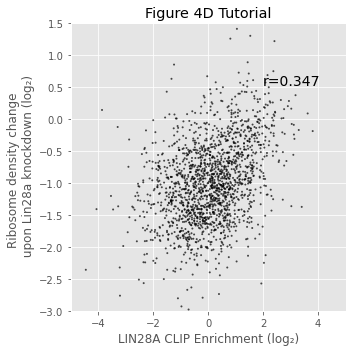

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

dfPlot4d = dfResult.sample(n=5000)
ax.scatter(x=dfPlot4d['LIN28A_enhce'], y=dfPlot4d['Rden_chng'], alpha=0.7, s=4, edgecolor='none', c='black', zorder=2)
ax.set_ylim((-3, 1.5))
ax.set_xlim((-5, 5))
ax.set_title('Figure 4D Tutorial')
ax.set_xlabel('LIN28A CLIP Enrichment (log\u2082)')
ax.set_ylabel('Ribosome density change \n upon Lin28a knockdown (log\u2082)')
ax.grid(True, axis = 'y', zorder =1)

fig.text(0.74,0.75,'r=0.347', fontsize=14)

plt.tight_layout()
plt.style.use(['ggplot'])
plt.savefig('Figure 4D Tutorial.png', dpi = 300)


In [14]:
from scipy import stats
dfEdited = dfResult.dropna()
stats.pearsonr(dfEdited['LIN28A_enhce'], dfEdited['Rden_chng'])

(0.3230428576920658, 0.0)

In [15]:
#############
##Figure 6A##
#############

#designate locations to each protein according to GO
def parseGOList(goList):
    compartmentDic = {'Nucleus':0, 'Membrane':0, 'Cytoplasm':0} #nucleus, integral membrane, cytoplasm
    for i in range (len(goList)):
        if 'nuc' in goList[i]:
            compartmentDic['Nucleus'] += 1.3
        elif 'mem' in goList[i]:
            compartmentDic['Membrane'] += 1.1
        elif 'cyt' in goList[i]:
            compartmentDic['Cytoplasm'] += 1
    for key, value in compartmentDic.items(): #return the most prevalent location stated via the GO
        if value == max(compartmentDic.values()):
            return key, value

#open uniprot file and assign locations to ensemble ids    
with open('./proteinLocal/uniprot-mus+musculus.tab') as inpfile: #open UniProt file 
        proteinPosDic = {}
        scorePosDic = {}
        for line in inpfile: #reading opened samfile line 
            species = line.split('\t')[2]
            if species == 'Mus musculus (Mouse)': #only consider Mouse origin proteins
                transcriptList = list(line.split('\t')[3].rstrip(';').split(';'))
                goList = list(line.split('\t')[4].rstrip('\n').split(';'))
                proteinPos, scorePos = parseGOList(goList) #return protein's position in the cell
                for i in range (len(transcriptList)):
                    transcriptName = transcriptList[i].split('[')[0] 
                    proteinPosDic [transcriptName] = proteinPos
                    scorePosDic [transcriptName] = scorePos
dfResult = dfResult.assign(Protein_Pos=pd.Series(proteinPosDic), Score_Pos=pd.Series(scorePosDic))
dfResult


,LIN28ACLIP,RPF_Lin28a,RPF_Luc,Rseq_Lin28a,Rseq_Luc,Rseq_ctrl,LIN28A_enhce,Rden_chng,Protein_Pos,Score_Pos
ENSMUST00000000001,2623.0,318.0,682.0,1514.0,1846.0,1913.0,0.455381,-0.814708,Membrane,5.5
ENSMUST00000000003,53.0,1.0,1.0,1.0,8.0,3.0,NaN,NaN,Nucleus,0.0
ENSMUST00000000010,96.0,5.0,6.0,5.0,1.0,21.0,NaN,NaN,Nucleus,2.6
ENSMUST00000000028,698.0,225.0,403.0,1030.0,940.0,1160.0,-0.732826,-0.972767,Nucleus,3.9
ENSMUST00000000033,158.0,15.0,11.0,8.0,2.0,29.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
ENSMUST00010126732,12.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN
ENSMUST00010181659,31.0,1.0,1.0,1.0,1.0,351.0,NaN,NaN,NaN,NaN
ENSMUST00010181660,15.0,2.0,1.0,1.0,1.0,350.0,NaN,NaN,NaN,NaN
ENSMUST00020181660,1091.0,459.0,716.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN


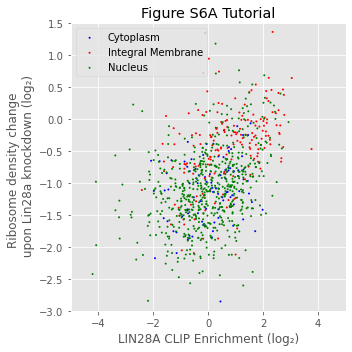

In [21]:
#draw figure S6A
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

dfPlotS6 = dfResult.sample(5000).dropna()
colors = {'Nucleus':'green', 'Membrane':'red', 'Cytoplasm':'blue'}
groups = dfPlotS6.groupby('Protein_Pos')
labelDic = {'Nucleus':'Nucleus', 'Membrane':'Integral Membrane', 'Cytoplasm':'Cytoplasm'}


for location, group in groups:
    ax.scatter(group.LIN28A_enhce, group.Rden_chng, alpha=1, s=4, edgecolor='none', c=colors[location], label=labelDic[location], zorder=2)
 
ax.set_ylim((-3, 1.5))
ax.set_xlim((-5, 5))
ax.set_title('Figure S6A Tutorial')
ax.set_xlabel('LIN28A CLIP Enrichment (log\u2082)')
ax.set_ylabel('Ribosome density change \n upon Lin28a knockdown (log\u2082)')
ax.legend()
ax.grid(True, axis = 'y', zorder=1)

plt.tight_layout()
plt.style.use(['ggplot'])
plt.savefig('Figure S6A Tutorial.png', dpi = 300)



In [51]:
#####################################################
#mini proj: RUN DAVID for top/bottom 50/100 gene list based on positioning scoring.
## https://david.ncifcrf.gov ##
#####################################################

#functions to create a list of transcripts with the highest density change and LIN28A enhancement
def generate_most_gene_list_CLIP (count, df):
    selected_df = df.dropna().nlargest(count, 'LIN28A_enhce', keep='all')
    list_from_df = selected_df.index.to_list()
    return list_from_df

def generate_least_gene_list_CLIP (count, df):
    selected_df = df.dropna().nsmallest(count, 'LIN28A_enhce', keep='first')
    list_from_df = selected_df.index.to_list()
    return list_from_df

def generate_most_gene_list_Rden (count, df):
    selected_df = df.dropna().nlargest(count, 'Rden_chng', keep='all')
    list_from_df = selected_df.index.to_list()
    return list_from_df

def generate_least_gene_list_Rden (count, df):
    selected_df = df.dropna().nsmallest(count, 'Rden_chng', keep='first')
    list_from_df = selected_df.index.to_list()
    return list_from_df

In [62]:
#top100_gene_string_pos = '\t'.join(generate_most_gene_list(100, dfResult[dfResult.Protein_Pos == 'Nucleus']))
top100_gene_string_CLIP = '\n'.join(generate_most_gene_list_CLIP(100, dfResult))
bottom100_gene_string_CLIP = '\n'.join(generate_least_gene_list_CLIP(100, dfResult))
top100_gene_string_Rden= '\n'.join(generate_most_gene_list_Rden(100, dfResult))
bottom100_gene_string_Rden = '\n'.join(generate_least_gene_list_Rden(100, dfResult))

top50_gene_string_CLIP = '\n'.join(generate_most_gene_list_CLIP(50, dfResult))
top50_gene_string_Rden= '\n'.join(generate_most_gene_list_Rden(50, dfResult))

with open("forDAVID_CLIP_top100.txt", "w") as f:
    #f.write("Top 100 Transcripts by CLIP Enrichment Scores\n")
    f.write(top100_gene_string_CLIP)

with open("forDAVID_CLIP_bottom100.txt", "w") as f:
    #f.write("Bottom 100 Transcripts by CLIP Enrichment Scores\n")
    f.write(bottom100_gene_string_CLIP)
    
with open("forDAVID_Rden_top100.txt", "w") as f:
    #f.write("Top 100 Transcripts by Ribosome Density Change Scores\n")
    f.write(top100_gene_string_Rden)
    
with open("forDAVID_Rden_bottom100.txt", "w") as f:
    #f.write("Bottom 100 Transcripts by Ribosome Density Change Scores\n")
    f.write(bottom100_gene_string_Rden)
    
with open("forDAVID_CLIP_top50.txt", "w") as f:
    f.write(top50_gene_string_CLIP)
    
with open("forDAVID_Rden_top50.txt", "w") as f:
    f.write(top50_gene_string_Rden)



In [61]:
#create complete ENSEMBL transcript list for DAVID runn limit to 3000 genes
dfDAVID = dfResult.dropna().sample(3000)
DAVID_string = '\n'.join(dfDAVID.index.to_list())
with open("forDAVID_sampled.txt", "w") as f:
    f.write(DAVID_string)